# Latent diffusion

This tutorial demonstrates how to generate images with latent diffusion models such as Stable Diffusion, Sana and Flux.

In [1]:
# !pip install diffusers transformers accelerate

In [2]:
import torch
import tqdm.auto

tqdm.auto.tqdm = tqdm.asyncio.tqdm  # disable HTML progress bars

from accelerate import cpu_offload
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

from azula.guidance import CFGDenoiser
from azula.plugins import flux, sana, sd
from azula.sample import zABSampler  # Adams-Bashforth sampler

device = "cuda"

In [3]:
_ = torch.manual_seed(42)

In [4]:
def postprocess(x):
    return torch.clip((x + 1) / 2, min=0, max=1)

## Stable Diffusion

In [5]:
denoiser, autoencoder, textencoder = sd.load_model("sd_1.5")
denoiser, autoencoder, textencoder = (
    denoiser.to(device),
    cpu_offload(autoencoder, device),
    cpu_offload(textencoder, device),
)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


In [6]:
with torch.no_grad():
    prompt = textencoder("an astronaut riding a horse in space")
    null = textencoder("")

We first try without classifier-free guidance (CFG). The resulting images do not follow the prompt well and have poor composition.

100%|########################################| 16/16 [00:00<00:00, 21.44step/s]


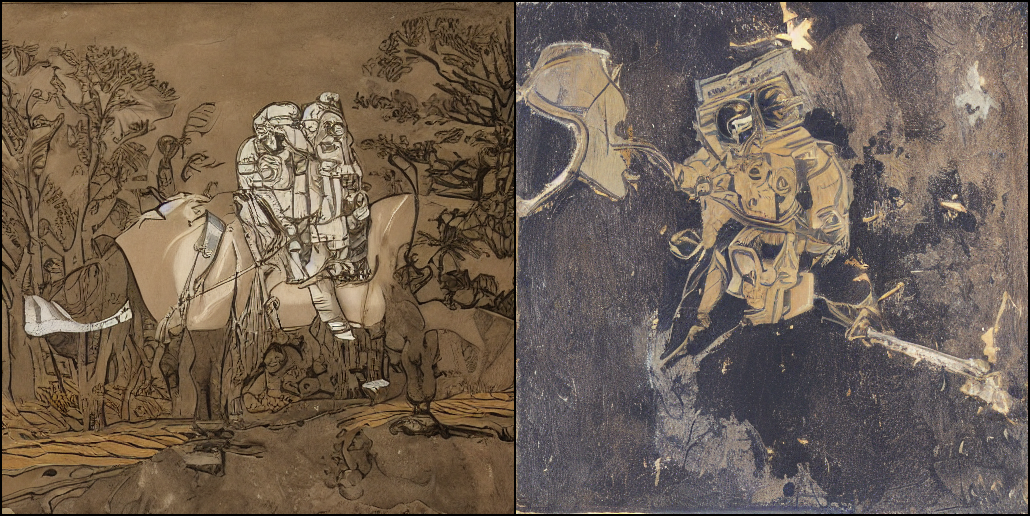

In [7]:
sampler = zABSampler(denoiser, steps=16)

z1 = sampler.init((2, 4, 64, 64), device=device)  # B C H W
z0 = sampler(z1, **prompt)

with torch.no_grad():
    x = autoencoder.decode(z0)

to_pil_image(make_grid(postprocess(x)))

Now with classifier-free guidance, which should boost prompt fidelity and image quality.

100%|########################################| 16/16 [00:00<00:00, 25.41step/s]


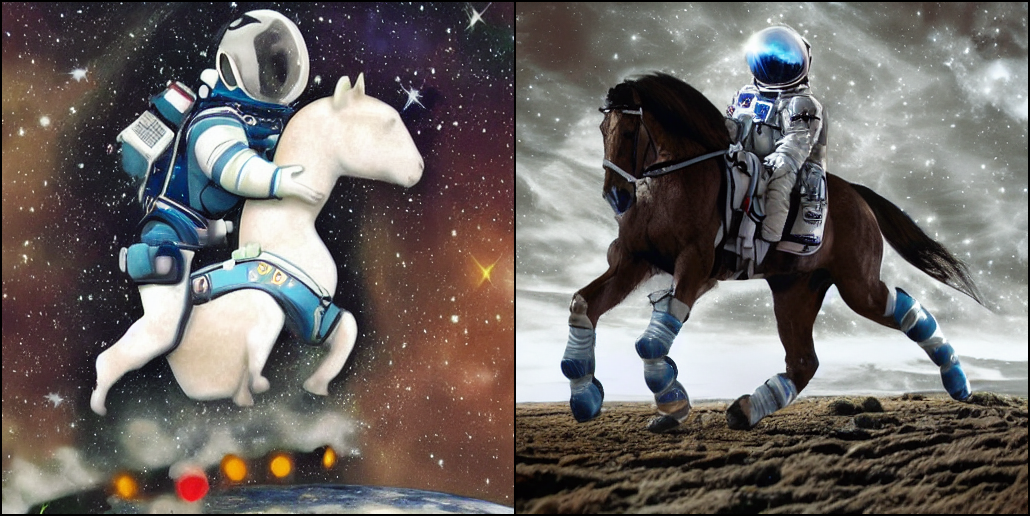

In [8]:
sampler = zABSampler(CFGDenoiser(denoiser), steps=16)

z1 = sampler.init((2, 4, 64, 64), device=device)
z0 = sampler(z1, positive=prompt, negative=null, guidance=3.0)

with torch.no_grad():
    x = autoencoder.decode(z0)

to_pil_image(make_grid(postprocess(x)))

In [9]:
del denoiser, autoencoder, textencoder

## Sana

In [10]:
denoiser, autoencoder, textencoder = sana.load_model("sana_1.6b_512")
denoiser, autoencoder, textencoder = (
    denoiser.to(device),
    cpu_offload(autoencoder, device),
    cpu_offload(textencoder, device),
)

Loading pipeline components...: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


In [11]:
with torch.no_grad():
    prompt = textencoder("a cyberpunk cat with a neon sign that says 'Sana'")
    null = textencoder("")

100%|########################################| 16/16 [00:00<00:00, 18.23step/s]


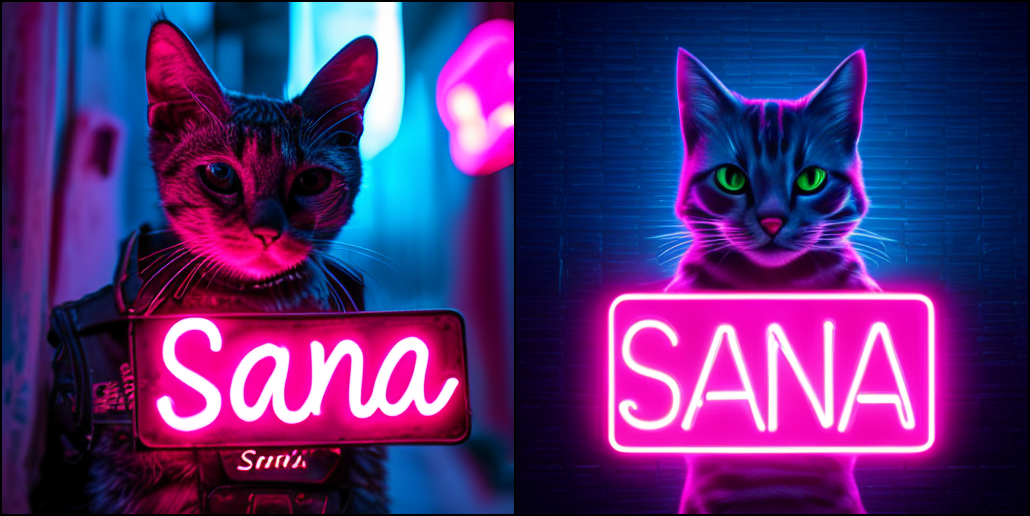

In [12]:
sampler = zABSampler(CFGDenoiser(denoiser), steps=16)

z1 = sampler.init((2, 32, 16, 16), device=device)
z0 = sampler(z1, positive=prompt, negative=null, guidance=3.0)

with torch.no_grad():
    x = autoencoder.decode(z0)

to_pil_image(make_grid(postprocess(x)))

In [13]:
del denoiser, autoencoder, textencoder

## Flux

In [14]:
denoiser, autoencoder, textencoder = flux.load_model()
denoiser, autoencoder, textencoder = (
    denoiser.to(device),
    cpu_offload(autoencoder, device),
    cpu_offload(textencoder, device),
)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.28it/s]


In [15]:
with torch.no_grad():
    prompt = textencoder("a forest with a big warning sign that says 'Flux'")

100%|########################################| 16/16 [00:01<00:00,  8.06step/s]


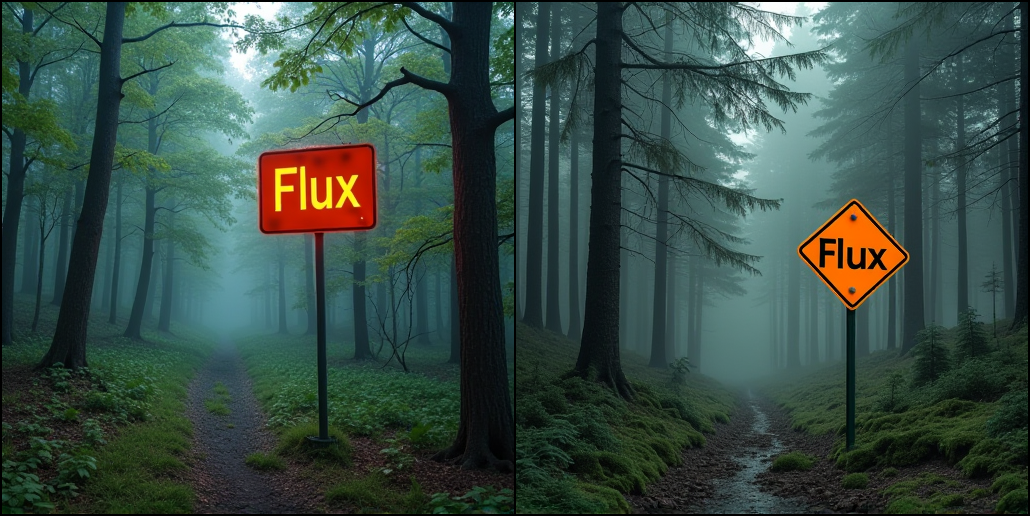

In [16]:
sampler = zABSampler(denoiser, steps=16)

z1 = sampler.init((2, 32, 32, 64), device=device)  # B H W C
z0 = sampler(z1, **prompt)

with torch.no_grad():
    x = autoencoder.decode(z0)

to_pil_image(make_grid(postprocess(x)))